In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')
df = df.iloc[:, :-2]
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

In [45]:
df.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,2004-03-10 23:00:00
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,2004-03-11 00:00:00
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,2004-03-11 01:00:00
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,2004-03-11 02:00:00
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,2004-03-11 03:00:00


In [46]:
missing_counts = (df == -200).sum()
print(missing_counts)

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Datetime            0
dtype: int64


Clean Data Set

In [47]:
# Replace -200 with NaN
df = df.drop(columns=['NMHC(GT)']) #dropped since majority null
cols_to_clean = [col for col in df.columns if col not in ['Date', 'Time', 'Datetime']]
df[cols_to_clean] = df[cols_to_clean].replace(-200, np.nan)

# Impute missing values using median
imputer = SimpleImputer(strategy='median')
df[cols_to_clean] = imputer.fit_transform(df[cols_to_clean])

# Reset index and drop rows with any remaining null values
df_cleaned = df.dropna().reset_index(drop=True)

Initialize Modeling Parameters

In [52]:
features = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
          'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'
          ]
X = df_cleaned[features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [88]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_cleaned['anomaly'] = iso_forest.fit_predict(X_scaled)

anomalies = df_cleaned[df_cleaned['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)} out of {df_cleaned.shape[0]} total records")

Number of anomalies detected: 94 out of 9357 total records


Histogram of Anomaly Scores

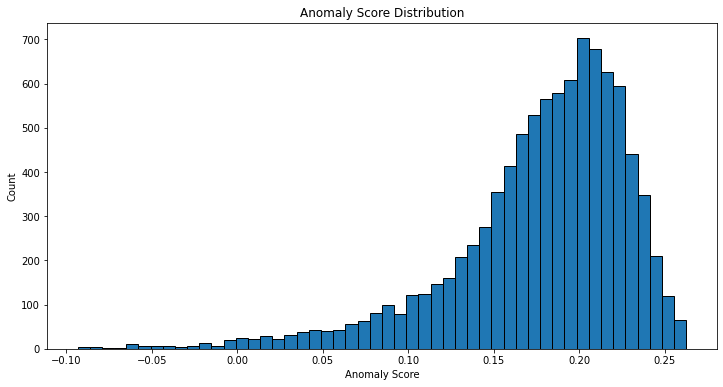

In [86]:
df_cleaned['anomaly_score'] = iso_forest.decision_function(X_scaled)
plt.figure(figsize=(12,6))
plt.hist(df_cleaned['anomaly_score'], bins=50, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.title('Anomaly Score Distribution')
plt.show()

 98%|===================| 9170/9357 [00:42<00:00]        

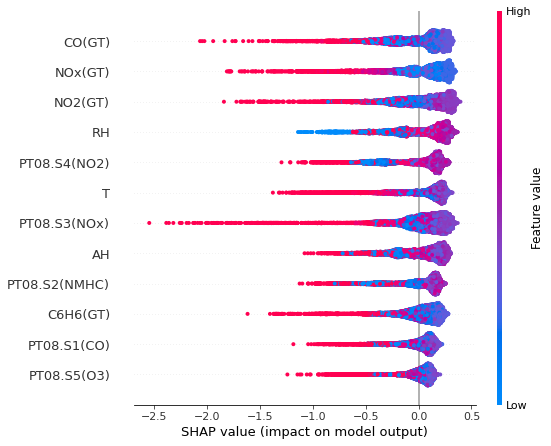

In [58]:
# Determin the most important features that are contributing to the anomalies
X_scaled_shap = pd.DataFrame(X_scaled, columns=features)

explainer = shap.Explainer(iso_forest, X_scaled_shap)
shap_values = explainer(X_scaled_shap)
shap.summary_plot(shap_values, X_scaled_shap)

Time Series Plots

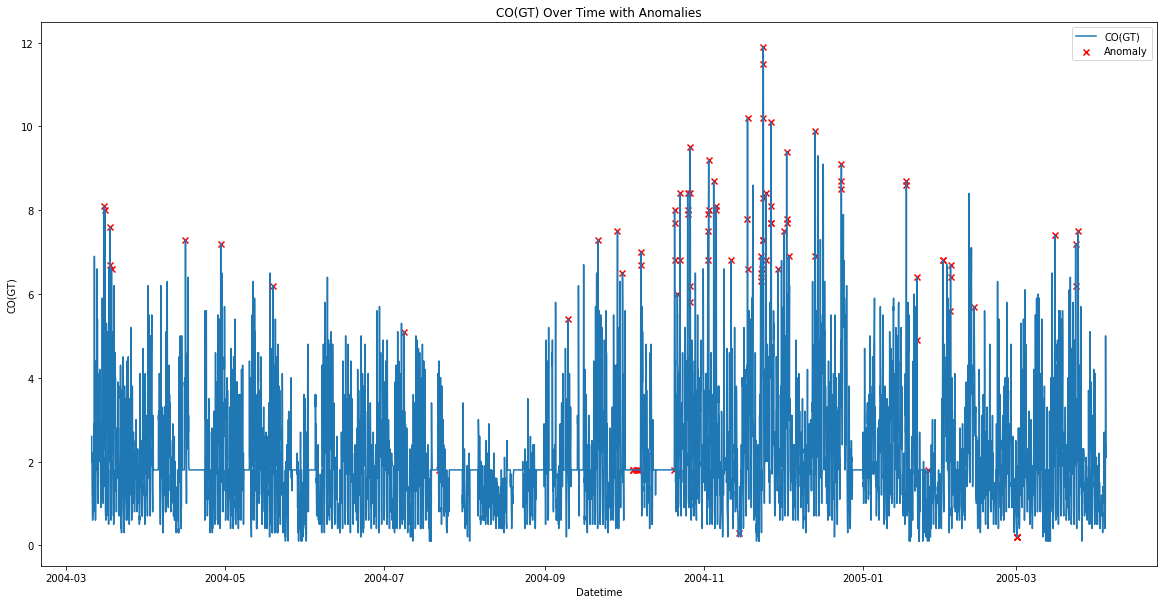

In [66]:
plt.figure(figsize=(20,10))
plt.plot(df_cleaned['Datetime'], df_cleaned['CO(GT)'], label='CO(GT)')
plt.scatter(
    df_cleaned.loc[df_cleaned['anomaly'] == -1, 'Datetime'],
    df_cleaned.loc[df_cleaned['anomaly'] == -1, 'CO(GT)'],
    color='red', label='Anomaly', marker='x'
)
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.title('CO(GT) Over Time with Anomalies')
plt.legend()
plt.show()

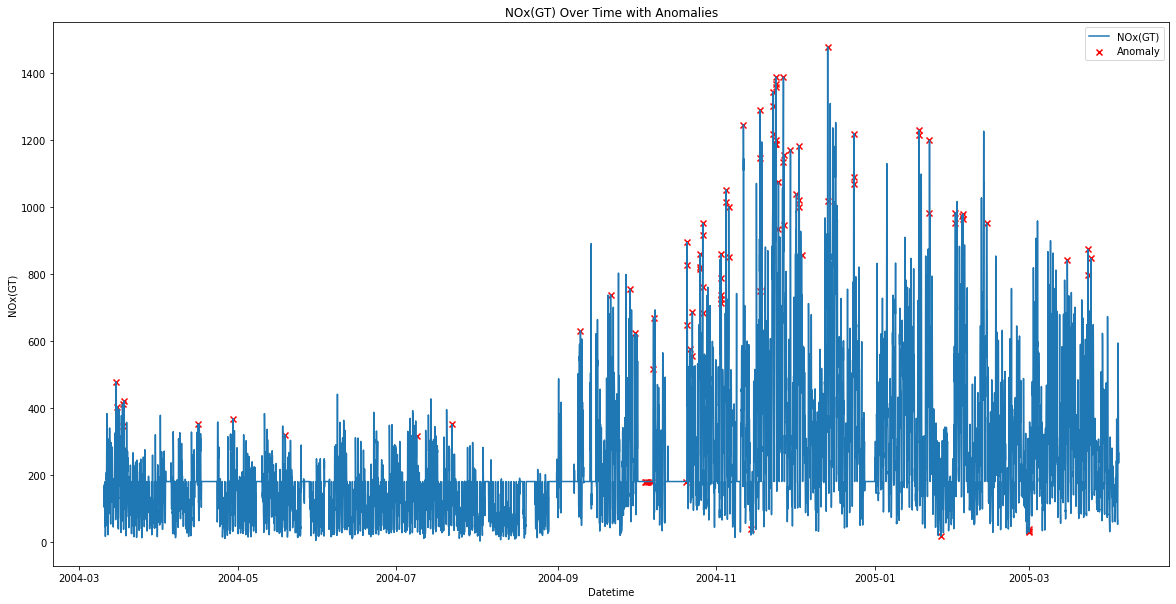

In [67]:
plt.figure(figsize=(20,10))
plt.plot(df_cleaned['Datetime'], df_cleaned['NOx(GT)'], label='NOx(GT)')
plt.scatter(
    df_cleaned.loc[df_cleaned['anomaly'] == -1, 'Datetime'],
    df_cleaned.loc[df_cleaned['anomaly'] == -1, 'NOx(GT)'],
    color='red', label='Anomaly', marker='x'
)
plt.xlabel('Datetime')
plt.ylabel('NOx(GT)')
plt.title('NOx(GT) Over Time with Anomalies')
plt.legend()
plt.show()

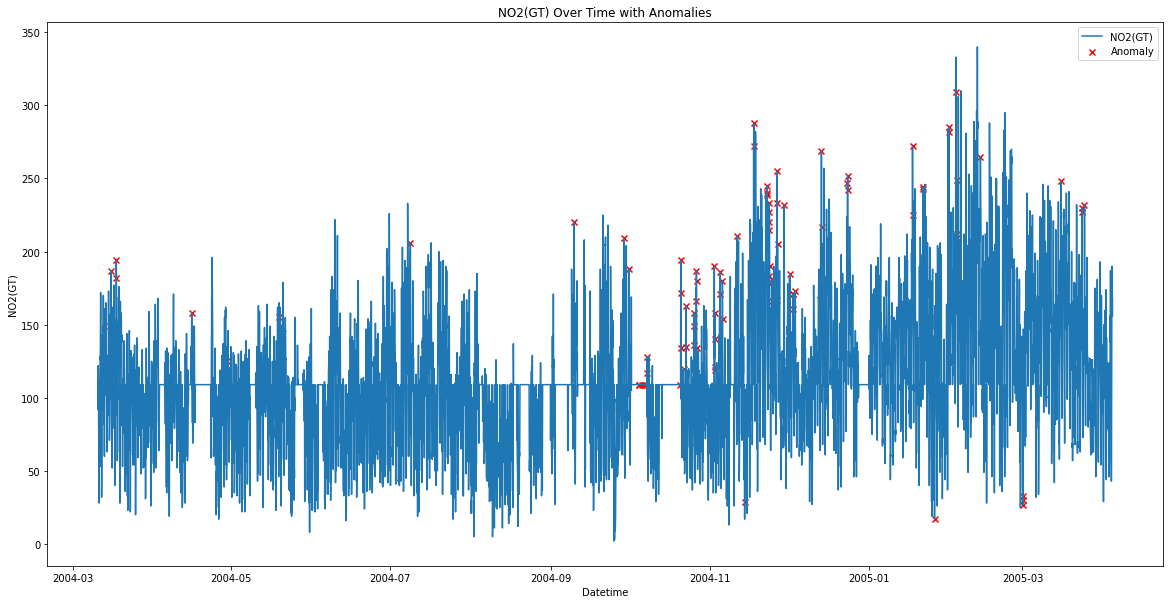

In [68]:
plt.figure(figsize=(20,10))
plt.plot(df_cleaned['Datetime'], df_cleaned['NO2(GT)'], label='NO2(GT)')
plt.scatter(
    df_cleaned.loc[df_cleaned['anomaly'] == -1, 'Datetime'],
    df_cleaned.loc[df_cleaned['anomaly'] == -1, 'NO2(GT)'],
    color='red', label='Anomaly', marker='x'
)
plt.xlabel('Datetime')
plt.ylabel('NO2(GT)')
plt.title('NO2(GT) Over Time with Anomalies')
plt.legend()
plt.show()

Scatter Plots

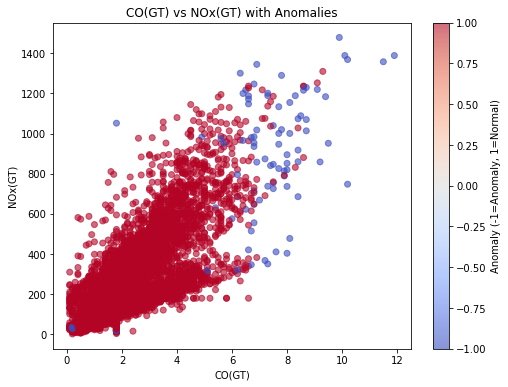

In [77]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_cleaned['CO(GT)'], df_cleaned['NOx(GT)'],
    c=df_cleaned['anomaly'], cmap='coolwarm', alpha=0.6
)
plt.xlabel('CO(GT)')
plt.ylabel('NOx(GT)')
plt.title('CO(GT) vs NOx(GT) with Anomalies')
plt.colorbar(label='Anomaly (-1=Anomaly, 1=Normal)')
plt.show()

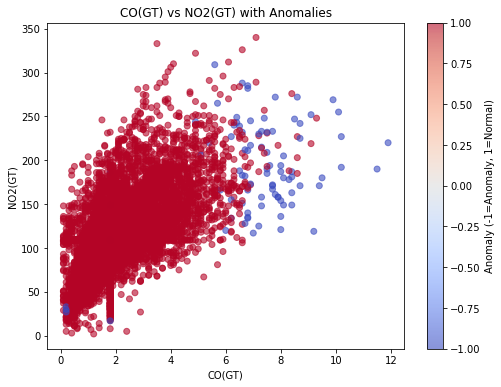

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_cleaned['CO(GT)'], df_cleaned['NO2(GT)'],
    c=df_cleaned['anomaly'], cmap='coolwarm', alpha=0.6
)
plt.xlabel('CO(GT)')
plt.ylabel('NO2(GT)')
plt.title('CO(GT) vs NO2(GT) with Anomalies')
plt.colorbar(label='Anomaly (-1=Anomaly, 1=Normal)')
plt.show()

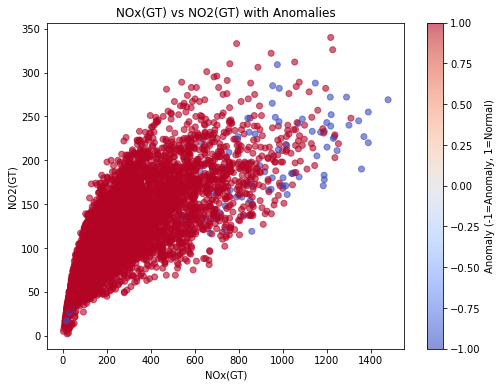

In [72]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_cleaned['NOx(GT)'], df_cleaned['NO2(GT)'],
    c=df_cleaned['anomaly'], cmap='coolwarm', alpha=0.6
)
plt.xlabel('NOx(GT)')
plt.ylabel('NO2(GT)')
plt.title('NOx(GT) vs NO2(GT) with Anomalies')
plt.colorbar(label='Anomaly (-1=Anomaly, 1=Normal)')
plt.show()